In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
import corner
import optax
import haiku as hk

In [2]:
key = jax.random.PRNGKey(366)

# Mean-Field Approximation for neural net posterior

Loosely based on https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/

Let us try to fit a mean field posterior to the posterior ofsome variable $\theta$. In this example, we are $\theta$ represent neural network weights.

$$y = F(x, \theta) + \sigma \, n, \quad n \sim N(0,1)$$ 

$$y|x = \frac{y-F(x, \theta)}{\sigma} \sim N(0,1).$$ 

Here, $F$ is a neural network with weights $\theta$ and input $x \in \mathbb{R}$ that outputs scalar $y \in \mathbb{R}$.

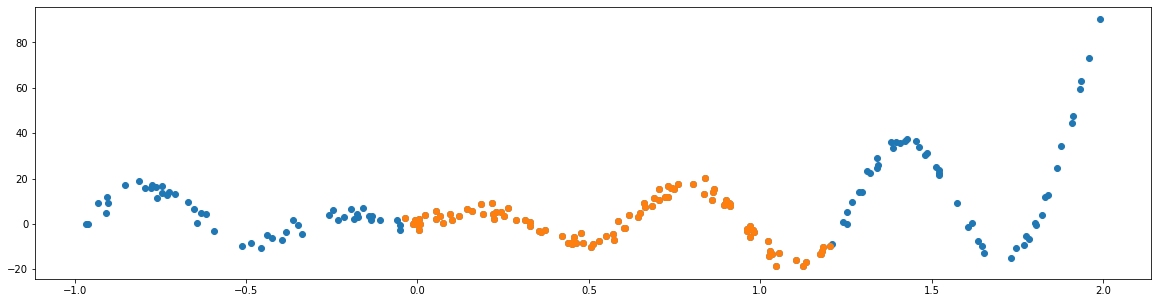

In [22]:
# Generate fake data
n_data_full = 200
train_start_index = 50
train_stop_index = 150
n_data = train_stop_index - train_start_index

# Input x
subkey,key=jax.random.split(key)
x_full = jnp.sort(jax.random.uniform(subkey, (n_data_full,)))*3-1
x_full = jnp.array([x_full]).T
x = x_full[train_start_index:train_stop_index,:]

# Gaussian noise
subkey,key=jax.random.split(key)
n_full = jax.random.normal(subkey, (n_data_full,))
n = n_full[train_start_index:train_stop_index]

# Noise intensity
sigma = 2.

# Generate data with some function
f = lambda x : 20*x*jnp.sin(10*x) + jnp.exp(x**2)
y_full = jax.vmap(f, in_axes=(0,))(x_full).flatten() + sigma * n_full
y = jax.vmap(f, in_axes=(0,))(x).flatten() + sigma * n

plt.figure(figsize=(20,5))
plt.plot(x_full, y_full, 'o');
plt.plot(x, y, 'o');

## Define a fully-connected neural network and mean squared error loss function.

In [23]:
def net_fn(x=x):
    mlp = hk.Sequential([
      hk.Linear(5), jax.nn.elu,
      hk.Linear(5), jax.nn.elu,
      hk.Linear(1),
    ])
    return mlp(x).flatten()

net = hk.without_apply_rng(hk.transform(net_fn))
opt = optax.adam(1e-3)

@jax.jit
def mse_loss(y_pred, y=y):
    '''mean squared error'''
    return 0.5*jnp.sum((y-y_pred)**2)/len(y_pred) 

@jax.jit
def l2_loss(theta):
    '''l2 regularization of weights'''
    return 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(theta))

@jax.jit
def total_loss(theta, x=x, y=y):
    '''mse + l2 loss'''
    y_pred = net.apply(theta, x)
    return mse_loss(y_pred,y)+ 1e-4 * l2_loss(theta)

@jax.jit
def update_net(theta, opt_state, x=x, y=y):
    """SGD with Adam"""
    grads = jax.grad(total_loss)(theta, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_theta = optax.apply_updates(theta, updates)
    return new_theta, opt_state

@jax.jit
def ema_update(theta, avg_theta):
    '''exponential moving average'''
    return optax.incremental_update(theta, avg_theta, step_size=0.01)

## Train neural net with ADAM to observe a point estimate

In [24]:
# Set up for training
theta = avg_theta = net.init(jax.random.PRNGKey(42), x[0])
opt_state = opt.init(theta)
n_dims = jnp.array([len(p.flatten()) for p in jax.tree_leaves(theta)]).sum() # total number of weights
print(f'Total number of weights (incl. biases): {n_dims}')

Total number of weights (incl. biases): 46


In [25]:
# Train network
for step in range(20001):
    if step % 2000 == 0:
        print(f'Loss: {total_loss(theta,x,y)}')
    # SGD on full-batch
    theta, opt_state = update_net(theta, opt_state, x, y)
    avg_theta = ema_update(theta, avg_theta)

Loss: 41.81199264526367
Loss: 10.375528335571289
Loss: 4.632536888122559
Loss: 2.399056911468506
Loss: 1.8844395875930786
Loss: 1.8164230585098267
Loss: 1.8008261919021606
Loss: 1.7912051677703857
Loss: 1.7851072549819946
Loss: 1.781653642654419
Loss: 1.7793506383895874


In [26]:
# save for later
nn_theta = avg_theta

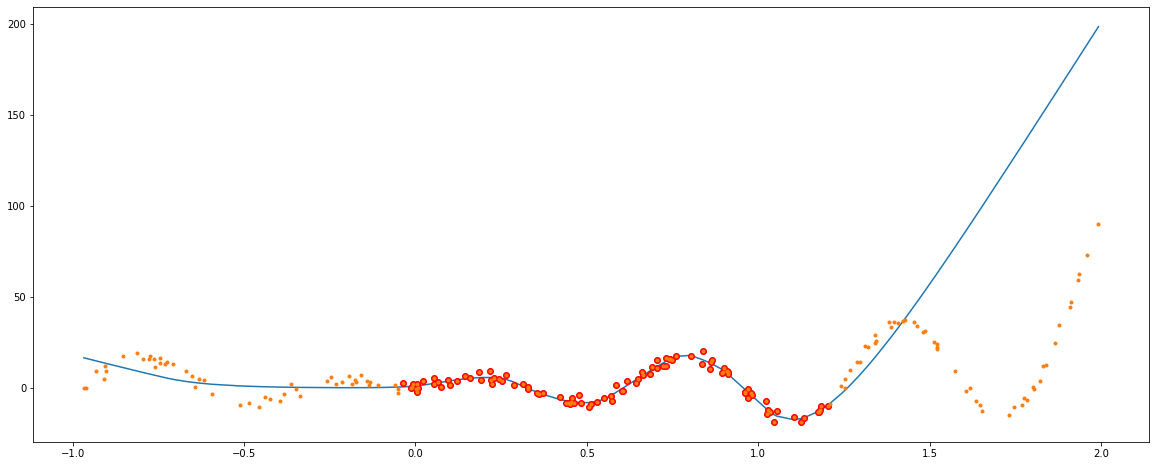

In [28]:
# Plot neural network results
plt.figure(figsize=(20,8))
plt.plot(x_full, net.apply(nn_theta, x=x_full))
plt.plot(x,y, 'ro');
plt.plot(x_full,y_full, '.');

## Mean Field Approximation Setup

We approximate the posterior for the weights $\theta = (\theta_1, \dots, \theta_N)$ using a product of 1D Gaussians. Reminder: $(x,y) = \big\{x_i, y_i \big\}_{i=1}^M$ is the set of $M$ training datapoints

$$\pi(\theta| x,y) \approx q(\theta) = \Pi_{i=1}^{N} q_i \big(\theta_i; \mu_i, \sigma_i^2 \big).$$

The goal is to optimize $\big\{\mu_i, \sigma_i^2 \big\}_{i=1}^N$ such that (reverse) $KL(\pi | q)$ is minimized. In practice, we maximises the ELBO, which works out to be

$$ELBO\Big(\big\{\mu_i, \sigma_i^2 \big\}_{i=1}^N \Big) = \mathbb{E}_{\theta \sim q}\big[-\log \pi(\theta) -\sum_{i=1}^N \log q_i(\theta_i) \big].$$

By construction of the mean field assumption, we can easily sample $\theta$ from $q$. This means we can easily estimate this expectation with Monte Carlo.

## Helper functions to deal with JAX trees

First three are taken from https://github.com/google-research/google-research/blob/master/bnn_hmc/utils/tree_utils.py

In [29]:
@jax.jit
def tree_add(a, b):
    '''add two trees elementwise'''
    return jax.tree_multimap(lambda e1, e2: e1+e2, a, b)

@jax.jit
def tree_minus(a, b):
    '''minus b from a elementwise'''
    return jax.tree_multimap(lambda e1, e2: e1-e2, a, b)

@jax.jit
def normal_like_tree(a,key):
    '''standard Gaussian sample in the tree shape'''
    treedef = jax.tree_structure(a)
    num_vars = len(jax.tree_leaves(a))
    all_keys = jax.random.split(key, num=(num_vars + 1))
    noise = jax.tree_multimap(lambda p, k: jax.random.normal(k, shape=p.shape), a,
                            jax.tree_unflatten(treedef, all_keys[1:]))
    return noise

@jax.jit
def tree_add_constant(a, c):
    '''add two trees elementwise'''
    return jax.tree_map(lambda e1: e1 + c, a)

@jax.jit
def tree_div(a, b):
    '''divide two trees elementwise'''
    return jax.tree_multimap(lambda e1, e2: e1/e2, a, b)

@jax.jit
def tree_mult(a, b):
    '''multiply two trees elementwise'''
    return jax.tree_multimap(lambda e1, e2: e1*e2, a, b)

@jax.jit
def tree_log(a):
    '''log every leaf in the tree'''
    return jax.tree_map(lambda e1 : jnp.log(e1), a)

@jax.jit
def tree_exp(a):
    '''exponentiate every leaf in the tree'''
    return jax.tree_map(lambda e1 : jnp.exp(e1), a)

@jax.jit
def tree_sq(a):
    '''square every leaf in the tree'''
    return jax.tree_map(lambda e1 : e1**2, a)

@jax.jit
def tree_sum(a):
    '''sum every leaf in the tree'''
    return sum([jnp.sum(p_a) for p_a in jax.tree_leaves(a)])

one_tree = tree_div(nn_theta,nn_theta) # a tree of ones
zero_tree = tree_minus(nn_theta,nn_theta) # a tree of zeros

## Define true posterior, mean field posterior, ELBO and grad ELBO

In [30]:
@jax.jit
def neg_log_posterior(theta, x=x, y=y):
    '''TARGET POSTERIOR.'''
    # --- NEG LOG LIKELIHOOD TERM ---
    # This bears some resemblance to MSE loss, except that
    # 1. we do not average this loss over number of datapoints,
    # 2. we use sigma**2 in the denomiator'''
    y_pred = net.apply(theta, x)
    neg_log_like = 0.5*jnp.sum((y-y_pred)**2)/(sigma**2)
    
    # --- NEG LOG PRIOR TERM ---
    # Looks similar to L2 loss
    # We use a Gaussian prior with zero mean and large variance
    neg_log_prior = 1e-4 * l2_loss(theta)
    return neg_log_like + neg_log_prior

@jax.jit
def neg_log_mean_field_posterior(theta, mean, std):
    '''Joint density of N independent 1-D gaussians (mean field assumption)'''
    # Exponential part of the Gaussian density
    # Note that std are the sqrt of diagonals of the covariance)
    # Formula = 0.5*((theta-mean)**2/std**2).sum() 
    part_1 = 0.5 * tree_sum(tree_sq(tree_div(tree_minus(theta, mean), std)))
    
    # The normalizing constant part
    # Formula = log(std).sum()
    part_2 = tree_sum(tree_log(std))
    
    return part_1 + part_2

@jax.jit
def mean_and_std(mean_field_params):
    '''open up the dictionary
    to return the mean and exponentiated log std'''
    mean = mean_field_params['mean']
    log_std = mean_field_params['log_std']
    std = tree_add_constant(tree_exp(log_std),1e-6)
    return mean, std

@jax.jit
def sample_theta(key, mean, std):
    '''sample one theta'''
    gauss_sample = normal_like_tree(nn_theta,key) # same shape as nn_theta
    theta = tree_add(mean, tree_mult(gauss_sample, std))
    return theta

@jax.jit
def sample_thetas(keys, mean, std):
    '''sample many theta for monte carlo estimation'''
    return jax.vmap(sample_theta, in_axes=(0,None,None))(keys, mean, std)

@jax.jit
def negative_ELBO(mean_field_params, key):
    
    # Prepare 100 draws of theta from mean field posterior
    keys = jax.random.split(key, 100)
    mean, std = mean_and_std(mean_field_params)
    thetas = sample_thetas(keys, mean, std)
    
    # true (neg log) posterior
    nlp = jax.vmap(neg_log_posterior)(thetas)
    
    # mean field approximation of (neg log) posterior
    nlp_mf = jax.vmap(neg_log_mean_field_posterior, in_axes=(0,None,None))(thetas, mean, std)
    
    return jnp.mean(nlp) - jnp.mean(nlp_mf)

value_and_grad_negative_ELBO = jax.jit(jax.value_and_grad(negative_ELBO))

## Minimize negative ELBO with ADAM

In [31]:
@jax.jit
def update_mean_field_params(mean_field_params, opt_state, key, x=x, y=y):
    """SGD with Adam"""
    value, grads = value_and_grad_negative_ELBO(mean_field_params, subkey)
    updates, opt_state = optimizer.update(grads, opt_state)
    mean_field_params = optax.apply_updates(mean_field_params, updates)
    return mean_field_params, opt_state, value

In [32]:
# Initialize mean field parameters
# Here, I think it is valid to set the starting mean to the neural net's estimate.
# To test the code however I start from close to 0.
mean_field_params = {'mean': tree_add_constant(zero_tree,0.1), 'log_std':tree_add_constant(zero_tree,0.1)}

In [38]:
start_learning_rate = 1e-4
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(mean_field_params)

In [39]:
# SGD Loop
for i in range(10001):
    subkey, key = jax.random.split(key)
    mean_field_params, opt_state, value = update_mean_field_params(mean_field_params,opt_state,key)
    if i % 1000 == 0:
        # compute loss
        keys = jax.random.split(key, 100)
        mean, std = mean_and_std(mean_field_params)
        thetas = sample_thetas(keys, mean, std)
        loss = jax.vmap(total_loss)(thetas).mean()
    
        print(f'Negative ELBO: {value:.4f} \t Loss: {loss:.4f}')

Negative ELBO: 120.6232 	 Loss: 3.8954
Negative ELBO: 111.2714 	 Loss: 4.8272
Negative ELBO: 101.0871 	 Loss: 5.1780
Negative ELBO: 94.9748 	 Loss: 5.2863
Negative ELBO: 90.0985 	 Loss: 5.6284
Negative ELBO: 86.3744 	 Loss: 5.9145
Negative ELBO: 83.4307 	 Loss: 6.3260
Negative ELBO: 80.7325 	 Loss: 6.3524
Negative ELBO: 78.1124 	 Loss: 6.3168
Negative ELBO: 75.3961 	 Loss: 6.3696
Negative ELBO: 71.8019 	 Loss: 6.3226


## Visualise some $\theta$ (neural net) samples from our mean-field posterior

In [40]:
mean, std = mean_and_std(mean_field_params)

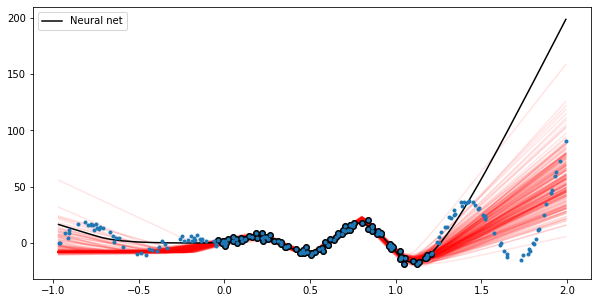

In [43]:
# Plot neural network results
plt.figure(figsize=(10,5))

for key_ in jax.random.split(key,200):
    theta = sample_theta(key_, mean, std)
    plt.plot(x_full, net.apply(theta, x_full), 'r', alpha=0.1)

plt.plot(x_full, net.apply(nn_theta, x_full), 'k', label='Neural net')
plt.plot(x,y, 'ko'); # train set
plt.plot(x_full,y_full, '.'); # full data set
plt.legend();